In [1]:
!pip install ..
!pip install datasets
!pip install pycocotools
!pip install bitsandbytes

Processing /home/jovyan/rashkov/ru-dolph
  Preparing metadata (setup.py) ... done
  Created wheel for rudolph: filename=rudolph-0.0.1rc10-py3-none-any.whl size=23517 sha256=325a60d2626cb40260c594eae3c23e4f04b6138e52d45747fd3e11dfbe14aeaa
  Stored in directory: /home/jovyan/.cache/pip/wheels/2b/3d/dc/a117001cc39aba083598dd3532c4e0ff93732272b507afb95e
Successfully built rudolph
  Attempting uninstall: rudolph
    Found existing installation: rudolph 0.0.1rc10
    Uninstalling rudolph-0.0.1rc10:
      Successfully uninstalled rudolph-0.0.1rc10


In [2]:
import torch
from rudalle import get_vae
from rudalle.utils import seed_everything

import sys
sys.path.insert(0, 'ru-dolph')

import os
from glob import glob
from os.path import join
from datetime import datetime

import torch
import bitsandbytes as bnb
from torch.utils.data import Dataset, DataLoader
import torchvision
import transformers
import more_itertools
import numpy as np
import json
from PIL import Image, ImageDraw
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm.auto import tqdm
from einops import rearrange
import youtokentome as yttm

import torchvision
from rudalle.image_prompts import ImagePrompts
from rudolph.model import get_rudolph_model, ruDolphModel, FP16Module
from rudolph import utils
from rudolph.model.utils import get_attention_mask
from rudalle import get_tokenizer, get_vae
from rudolph.api import ruDolphApi

import datasets
import random
from pycocotools.coco import COCO
import json
from PIL import Image

from typing import Any, Callable, Optional, Tuple, List

In [3]:
from rudolph.model import get_rudolph_model

In [4]:
device = 'cuda'

In [5]:
torch.cuda.empty_cache()

In [6]:
model = get_rudolph_model('1.3B', pretrained=True, fp16=True, device='cuda')

NEW VERSION!!!!!!
Creating object detection mod model


/home/jovyan/.imgenv-rudolph-object-detection-0/lib/python3.7/site-packages/huggingface_hub/file_download.py:595: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


In [7]:
tokenizer = get_tokenizer()
vae = get_vae(dwt=False).to(device)

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


In [8]:
class Args():
    def __init__(self, model, checkpoint_path):
        self.device = model.get_param('device')
        self.l_text_seq_length = model.get_param('l_text_seq_length')
        self.r_text_seq_length = model.get_param('r_text_seq_length')
        self.image_tokens_per_dim = model.get_param('image_tokens_per_dim')
        self.image_seq_length = model.get_param('image_seq_length')
        self.epochs = 1
        self.save_path= checkpoint_path
        self.model_name = 'rudolph_coco_left_text_category_2_'
        self.save_every = 10000
        self.bs = 4
        self.clip = 1.0
        self.lr = 2e-5
        self.wandb = False
        self.lt_loss_weight = 0.01
        self.img_loss_weight = 0.01
        self.rt_loss_weight = 7
        self.category_weight = 2
        self.all_localization_loss_weight = 0.01
        self.bin_size = 8
        self.image_size = self.image_tokens_per_dim * self.bin_size
        self.categories_num = 90
        
checkpoint_path = '../model/checkpoints/'
args = Args(model, checkpoint_path)
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

In [9]:
SPC_TOKENS = {
    '<LT_UNK>': 16384,
    '<RT_UNK>': 16385,
    '<LT_T2I>': 16386,
    '<LT_I2T>': 16387,
    '<LT_T2T>': 16388,
    '<RT_I2T>': 16389,
    
    '<LT_TQA>': 16390,
    '<RT_TQA>': 16391,
    '<LT_OD>': 16392,
    '<RT_OD>': 16393,
}

In [ ]:
for n in range(args.image_tokens_per_dim):
    n_token = SPC_TOKENS['<RT_OD>']+1+n
    SPC_TOKENS['<RT_OD'+str(n)+'>'] = n_token
last_spc_token = n_token

for cat_n in range(args.categories_num+1):
    n_token = last_spc_token + 1 + cat_n
    SPC_TOKENS['<RT_ODC'+str(cat_n)+'>'] = n_token

In [11]:
SPC_TOKENS

{'<LT_UNK>': 16384,
 '<RT_UNK>': 16385,
 '<LT_T2I>': 16386,
 '<LT_I2T>': 16387,
 '<LT_T2T>': 16388,
 '<RT_I2T>': 16389,
 '<LT_TQA>': 16390,
 '<RT_TQA>': 16391,
 '<LT_OD>': 16392,
 '<RT_OD>': 16393,
 '<RT_OD0>': 16394,
 '<RT_OD1>': 16395,
 '<RT_OD2>': 16396,
 '<RT_OD3>': 16397,
 '<RT_OD4>': 16398,
 '<RT_OD5>': 16399,
 '<RT_OD6>': 16400,
 '<RT_OD7>': 16401,
 '<RT_OD8>': 16402,
 '<RT_OD9>': 16403,
 '<RT_OD10>': 16404,
 '<RT_OD11>': 16405,
 '<RT_OD12>': 16406,
 '<RT_OD13>': 16407,
 '<RT_OD14>': 16408,
 '<RT_OD15>': 16409,
 '<RT_OD16>': 16410,
 '<RT_OD17>': 16411,
 '<RT_OD18>': 16412,
 '<RT_OD19>': 16413,
 '<RT_OD20>': 16414,
 '<RT_OD21>': 16415,
 '<RT_OD22>': 16416,
 '<RT_OD23>': 16417,
 '<RT_OD24>': 16418,
 '<RT_OD25>': 16419,
 '<RT_OD26>': 16420,
 '<RT_OD27>': 16421,
 '<RT_OD28>': 16422,
 '<RT_OD29>': 16423,
 '<RT_OD30>': 16424,
 '<RT_OD31>': 16425,
 '<RT_ODC0>': 16426,
 '<RT_ODC1>': 16427,
 '<RT_ODC2>': 16428,
 '<RT_ODC3>': 16429,
 '<RT_ODC4>': 16430,
 '<RT_ODC5>': 16431,
 '<RT_ODC6>': 

In [12]:
class RightDownPad:
    def __call__(self, image):
        _, h, w = image.size()
        max_wh = max(w, h)
        hp = int(max_wh - w)
        vp = int(max_wh - h)
        padding = [0, 0, hp, vp]
        return TF.pad(image, padding)
    
image_transform = T.Compose([
    T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
    T.ToTensor(),
    T.Resize((args.image_size, args.image_size))
    ])

In [13]:
exclude_list = np.load('../../data/coco_exclude.npy')

In [14]:
class CocoDetection(Dataset):
    spc_id = -1

    def __init__(
        self,
        root: str,
        ann_file: str,
        tokenizer,
        rus_categories,
        exclude_list,
        args,
        image_transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        super().__init__()
        
        self.tokenizer = tokenizer
        self.tokenizer_eos_id = tokenizer.eos_id
        self.tokenizer_bos_id = tokenizer.bos_id
        self.spc_tokens = SPC_TOKENS

        self.coco = COCO(ann_file)
        self.idxs = list(sorted(self.coco.imgs.keys()))
        for ex_img in exclude_list:
            self.idxs.remove(ex_img)
            
        self.categories = self.coco.dataset['categories']
        self.cat_idxs = list([cat['id'] for cat in self.categories])
        self.cat_idxs_map = {}
        for i, cat in enumerate(self.categories):
            self.cat_idxs_map[str(cat['id'])] = i
        
        self.root = root
        
        self.image_size = args.image_size
        self.bin_size = args.bin_size
        self.r_text_seq_length = args.r_text_seq_length
        self.l_text_seq_length = args.l_text_seq_length
        self.image_tokens_per_dim = args.image_tokens_per_dim
        
        self.image_transform = image_transform
        
        self.encoded_left_text = self.encode_text(rus_categories, args.l_text_seq_length, add_special = True)
        self.encoded_left_text[torch.where(self.encoded_left_text == self.spc_id)] = self.spc_tokens['<LT_OD>']
        
            
    def _load_image(self, idx: int) -> Image.Image:
        coco_image = self.coco.loadImgs(idx)[0]["file_name"]
        return Image.open(os.path.join(self.root, coco_image))

    def _load_target(self, idx: int) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(idx))
    
    def resize_bbox(self, bbox, img_size):
        bbox_x0 = bbox[0]
        bbox_y0 = bbox[1]
        bbox_x1 = bbox_x0+bbox[2]
        bbox_y1 = bbox_y0+bbox[3]
        
        img_w = img_size[0]
        img_h = img_size[1]
        
        max_wh = max(img_w,img_h)

        resized_x0 = int(bbox_x0*self.image_size/img_w)
        resized_y0 = int(bbox_y0*self.image_size/img_h)
        resized_x1 = int(bbox_x1*self.image_size/img_w)
        resized_y1 = int(bbox_y1*self.image_size/img_h)
        return [resized_x0,resized_y0,resized_x1, resized_y1]
    
    def encode_bbox(self, resized_bbox):
        
        bbox_x0_bin = resized_bbox[0]//self.bin_size
        bbox_y0_bin = resized_bbox[1]//self.bin_size
        bbox_x1_bin = min(resized_bbox[2]//self.bin_size, self.image_tokens_per_dim-1)
        bbox_y1_bin = min(resized_bbox[3]//self.bin_size, self.image_tokens_per_dim-1)
        
        new_bbox_tokens = [SPC_TOKENS['<RT_OD'+str(bbox_x0_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_y0_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_x1_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_y1_bin)+'>']]
        
        return new_bbox_tokens
    
    def encode_target(self, target, img_size):
        encoded_target = [self.tokenizer_bos_id, SPC_TOKENS['<RT_OD>']]
        for i,tar in enumerate(target):
            paper_cat = tar['category_id']
            cat = self.cat_idxs_map[str(paper_cat)]
            bbox = tar['bbox']
            
            resized_bbox = self.resize_bbox(bbox, img_size)
            encoded_bbox = self.encode_bbox(resized_bbox)
            
            encoded_cat = SPC_TOKENS['<RT_ODC'+str(cat)+'>']
            
            for loc_token in encoded_bbox:
                encoded_target.append(loc_token)
            encoded_target.append(encoded_cat)
            
        encoded_target.append(self.tokenizer_eos_id)
        
        return torch.Tensor(encoded_target+[0]*(self.r_text_seq_length-len(encoded_target)))
    
    def encode_text(self, text, text_seq_length, add_special = True):
        tokens = self.tokenizer.tokenizer.encode([text], output_type=yttm.OutputType.ID)[0]
        bos = [self.tokenizer.bos_id]
        if add_special:
            bos.append(self.spc_id)
        tokens = bos + tokens + [self.tokenizer.eos_id]
        return self.tokenizer.prepare_tokens(tokens, text_seq_length)
        
    def __getitem__(self, index):
        idx = self.idxs[index]
        image = self._load_image(idx)
        img_size = image.size
        transformed_image = self.image_transform(image)
        
        target = self._load_target(idx)
        encoded_target = self.encode_target(target, img_size)

        return self.encoded_left_text, transformed_image, encoded_target      
    
    def __len__(self):
        return len(self.idxs)

In [15]:
cat_rus_names = ["человек","велосипед","автомобиль","мотоцикл","самолёт","автобус","поезд","грузовик","лодка",
                 "светофор","гидрант","знак стоп","парковочный счетчик","скамейка","птица","кошка","собака",
                "лошадь","овца","корова","слон","медведь","зебра","жираф","рюкзак","зонт","сумочка","галстук",
                "чемодан","фрисби","лыжи","сноуборд","спортивный мяч","воздушный змей","бейсбольная бита",
                 "бейсбольная перчатка","скейтборд","доска для сёрфинга","теннисная ракетка","бутылка","бокал для вина",
                 "чашка","вилка","нож","ложка","миска","банан","яблоко","сэндвич","апельсин","брокколи","морковь",
                 "ход-дог","пицца","пончик","торт","стул","диван","растение в горшке","кровать","обеденный стол","туалет","телевизор",
                 "ноутбук","компьютерная мышь","пульт","клавиатура","мобильный телефон","микроволновка","духовка",
                 "тостер","раковина","холодильник","книга","часы","ваза","ножницы","плюшевый мишка","фен","зубная щётка"]

In [16]:
coco_dataset = CocoDetection(root=r'../../data/train2017',
                             ann_file=r'../../data/annotations/instances_train2017.json',
                             image_transform=image_transform,
                             tokenizer=tokenizer,
                             args = args,
                             exclude_list=exclude_list,
                             rus_categories="|".join(cat_rus_names)
                            )

loading annotations into memory...
Done (t=13.21s)
creating index...
index created!


In [17]:
train_dataloader = DataLoader(coco_dataset, batch_size=args.bs, shuffle=True, drop_last=True)

In [18]:
def freeze(
    model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
):
    for name, p in model.module.named_parameters():
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
    return model

In [19]:
model.train()
optimizer = bnb.optim.Adam8bit(model.parameters(), lr=args.lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=args.lr, final_div_factor=500, 
    steps_per_epoch=len(train_dataloader), epochs=args.epochs
)

In [20]:
def train(model, optimizer, scheduler, args: Args, train_dataloader, from_checkpoints = False):
    """
      args - arguments for training

      train_dataloader - VisualGenomeDataset
      """
    loss_logs = []
    encoded_right_text = None
    #try:
    t_steps = len(train_dataloader)*args.epochs
    progress = tqdm(total = t_steps, desc='🦌🦌🦌finetuning process🦌🦌🦌')

    save_counter = 0
    start_epoch = 0

    if from_checkpoints:
        save_counter = max([int(f.split('_')[-1].split('.')[0]) for f in os.listdir(args.save_path) if f.startswith(args.model_name)])
        model, optimizer, start_epoch, loss_logs = load_checkpoint(model, optimizer, loss_logs, filename=os.path.join(args.save_path,f"{args.model_name}state_{save_counter}.pt"))
        start_epoch -= 1

    for epoch in range(start_epoch, args.epochs):

        for encoded_left_text, images, encoded_right_text in train_dataloader: #, prompt, image, locs

            bs_text = encoded_right_text.shape[0]

            images = images.to(device)

            image_seq_length = args.image_tokens_per_dim ** 2
            total_seq_length = args.l_text_seq_length + image_seq_length + args.r_text_seq_length
            encoded_images = vae.get_codebook_indices(images, disable_gumbel_softmax=True)

            attention_mask_text = get_attention_mask(bs_text, args.l_text_seq_length,
                                             args.image_tokens_per_dim, 
                                             args.r_text_seq_length, args.device)
            
            input_ids_text = torch.cat((encoded_left_text.to(args.device).int(),
                            encoded_images.int(),
                            encoded_right_text.to(args.device).int()), dim=1)
            loss, loss_values = model.forward(input_ids_text.long(), attention_mask_text, 
                                                             lt_loss_weight=args.lt_loss_weight,
                                                             img_loss_weight=args.img_loss_weight, 
                                                             rt_loss_weight=args.rt_loss_weight,
                                              return_loss=True,
                                              category_weight=args.category_weight
                                             )


            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(),args.clip)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            save_counter += 1
            if save_counter % args.save_every == 0:
                print(f'Saving checkpoint here {args.model_name}_rudolph_{save_counter}.pt')
                plt.plot(loss_logs)
                plt.show()
                state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
                         'optimizer': optimizer.state_dict(), 'losslogger': loss_logs}
                torch.save(
                    model.state_dict(),
                    os.path.join(args.save_path,f"{args.model_name}rudolph_{save_counter}.pt")
                )
                torch.save(
                    state,
                    os.path.join(args.save_path,f"{args.model_name}state_{save_counter}.pt")
                )

            loss_logs+=[loss.item()]
            progress.update()
            progress.set_postfix({"loss": loss.item()})

        print(f'Complitly tuned and saved here  {args.model_name}__object_detection_last.pt')
        plt.plot(loss_logs)
        plt.show()
        torch.save(
            model.state_dict(),
            os.path.join(args.save_path,f"{args.model_name}object_detection_last.pt")
        )
    '''except KeyboardInterrupt:


        print(f'What for did you stopped? Please change model_path to /{args.save_path}/{args.model_name}-rudolf_Failed_train')
        plt.plot(loss_logs)
        plt.show()

        torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.model_name}-rudolf_Failed_train.pt")
                )
    except Exception as err:
        print(encoded_right_text)
        print(f'Failed with {err}')'''

🦌🦌🦌finetuning process🦌🦌🦌:   0%|          | 0/28603 [00:00<?, ?it/s]

catrgory loss tensor(144.8625, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(113.1067, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(65.3342, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(48.2231, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(78.3219, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(65.8272, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(113.0249, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(94.7488, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(236.7363, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(168.1677, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(75.4166, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(179.4545, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(89.9772, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(121.2161, device='cuda:0', grad_fn=<MulBackward0>)

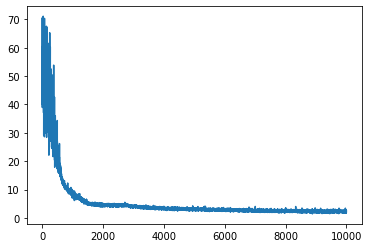

catrgory loss tensor(2.7523, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.7265, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(5.4695, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(4.3661, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(2.3742, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(2.4676, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(4.0621, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.6719, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.0167, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(6.1355, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.9575, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.3641, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(4.8425, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(2.9667, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor

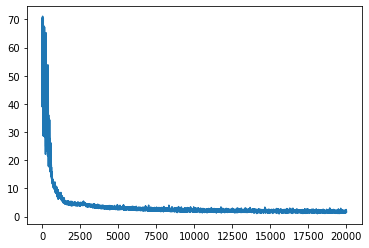

catrgory loss tensor(1.4427, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(5.5289, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(7.6344, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.5372, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(0.2931, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(2.2185, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.9525, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.8502, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.7972, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.2722, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.6852, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.7891, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(1.5529, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor(2.2913, device='cuda:0', grad_fn=<MulBackward0>)
catrgory loss tensor

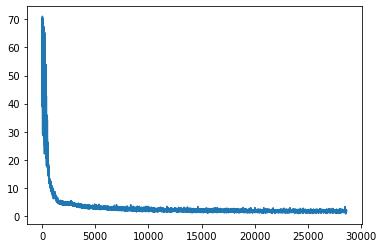

In [21]:
model = freeze(
    model=model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
)

train(model, optimizer, scheduler, args, train_dataloader, from_checkpoints=False)

In [43]:
coco_val_set = COCO(r'../../data/annotations/instances_val2017.json')
root = r'../../data/val2017'

exclude_val_list = []

for idx in coco_set.imgs.keys():
    target = coco_set.loadAnns(coco_set.getAnnIds(idx))
    if len(target)>25:
        exclude_val_list.append(idx)
    else:
        try:
            coco_image = coco_val_set.loadImgs(idx)[0]["file_name"]
            Image.open(os.path.join(root, coco_image))
        except:
            exclude_val_list.append(idx)

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tr

In [45]:
np.save(file='../../data/coco_val_exclude.npy', arr=np.array(exclude_val_list))

In [22]:
def loc_to_coords(token:int) -> float:
    num_token = token - SPC_TOKENS['<RT_PG>']-1
    return args.bin_size*num_token

def calc_area(bbox):
    w = bbox[2]-bbox[0]
    h = bbox[3]-bbox[1]
    return w*h

def tokens_to_bbox(tokens):
    bbox = torch.zeros(1,4)
    bbox[0,0] = loc_to_coords(tokens[0])
    bbox[0,1] = loc_to_coords(tokens[1])
    bbox[0,2] = loc_to_coords(tokens[2])
    bbox[0,3] = loc_to_coords(tokens[3])
    return bbox

def tokens_iou(pred_tokens, ground_truth_bbox):
    pred_bbox = tokens_to_bbox(pred_tokens)
    print(pred_bbox,ground_truth_bbox)
    iou = ops.box_iou(ground_truth_bbox, pred_bbox)
    return iou

In [23]:
class ruDolphPhraseGroundingApi(ruDolphApi):
    def __init__(self, model, tokenizer, vae, spc_tokens=None, quite=False, *, bs=24, q=0.5, txt_top_k=64,
                 img_top_k=768, txt_top_p=0.8, img_top_p=0.99, txt_temperature=0.9, img_temperature=1.0):
        
        super().__init__(model = model, tokenizer = tokenizer, vae = vae, spc_tokens = spc_tokens, quite = quite, bs = bs, q = q, txt_top_k = txt_top_k,
                 img_top_k = img_top_k, txt_top_p = txt_top_p, img_top_p = img_top_p, txt_temperature = txt_temperature, img_temperature = img_temperature)
    
    def generate_text_answers(self, image_tokens, left_text, vocab_size, top_k, top_p, temperature=1.0,
                              use_cache=True, template='', allowed_token_ids=None, special_token=''):
        '''
            Generate right text tokens.
        '''
        self.model.eval()
        torch.cuda.empty_cache()
        generated_tokens = []
        chunk_bs = left_text.shape[0]
        
        template = template.lower().strip()
        template_encoded = self.encode_text(template, text_seq_length=self.r_text_seq_length)
        
        template_size = (template_encoded != 0).sum() - 1  # eos
        
        template_encoded = template_encoded[:template_size]
        template_encoded[torch.where(template_encoded == self.spc_id)] = self.spc_tokens[special_token]

        with torch.no_grad():
            attention_mask = self.get_attention_mask(chunk_bs)

            out = torch.cat((
                left_text.to(self.device),
                image_tokens,
                template_encoded.repeat(chunk_bs, 1).to(self.device),
            ), dim=1)

            cache = None
            iter_range = range(
                self.l_text_seq_length + self.image_seq_length + template_size, 
                self.l_text_seq_length + self.image_seq_length + self.r_text_seq_length
            )
            
            if not self.quite:
                iter_range = tqdm(iter_range)
                
            for _ in iter_range:  
                logits, cache = self.model(out, attention_mask, cache=cache, use_cache=use_cache, return_loss=False)
                
                logits = logits[:, -1, :self.vocab_size]
            
                if allowed_token_ids:
                    logits = logits[:, allowed_token_ids]
            
                logits /= temperature
                filtered_logits = transformers.top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
                probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
                sample = torch.multinomial(probs, 1)
            
                if allowed_token_ids:
                        sample = torch.tensor(allowed_token_ids).to(self.device)[sample]
            
                indexes = torch.where(sample >= self.vocab_size - self.l_text_seq_length)
                sample[indexes] = 3
                out = torch.cat((out, sample), dim=-1)

            generated_tokens.append(out[:, -self.r_text_seq_length:])

        tokens = torch.cat(generated_tokens)[:,:]

        return tokens

In [137]:
def decode_right(right_tokens, length=None, scores=True):
    boxes = torch.zeros((length, 4))
    labels = (SPC_TOKENS['<RT_ODC80>']-SPC_TOKENS['<RT_ODC0>'])*torch.ones(length)
    scores = torch.zeros(length)
    
    for k in range(len(right_tokens)//5):
        labels[k] = right_tokens[(k+1)*5-1].unsqueeze(0).cpu() - SPC_TOKENS['<RT_ODC0>']
        boxes[k,:] = right_tokens[k*5:(k+1)*5-1].unsqueeze(0).cpu()
        scores[k] = 1
        
    boxes -= SPC_TOKENS['<RT_OD0>']*torch.ones((length, 4))
    boxes *= args.bin_size

    return [{'boxes':boxes, 'labels':labels, 'scores':scores}]

In [25]:
exclude_val_list = np.load('../../data/coco_val_exclude.npy')

In [26]:
coco_dataset_val = CocoDetection(root=r'../../data/val2017',
                             ann_file=r'../../data/annotations/instances_val2017.json',
                             image_transform=image_transform,
                             tokenizer=tokenizer,
                             args = args,
                             exclude_list=exclude_val_list,
                             rus_categories="|".join(cat_rus_names)
                            )

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [ ]:
api = ruDolphPhraseGroundingApi(model, tokenizer, vae, spc_tokens=SPC_TOKENS)
metric = MeanAveragePrecision()
pred_lens = []
tgt_lens = []
preds = []
tgts = []
allowed_token_ids = list(SPC_TOKENS.values())+[0,3]

val_dataloader = DataLoader(coco_dataset_val, batch_size=1, shuffle=False)

for batch in val_dataloader:
    encoded_left_text, images, encoded_right_text = batch
    
    bs_text = encoded_left_text.shape[0]

    images = images.to(device)

    image_seq_length = args.image_tokens_per_dim ** 2
    total_seq_length = args.l_text_seq_length + image_seq_length + args.r_text_seq_length
    encoded_images = vae.get_codebook_indices(images, disable_gumbel_softmax=True)

    ## Генерируем правые текстовые токены
    pred_tokens = api.generate_text_answers(encoded_images, encoded_left_text.type(torch.LongTensor), api.vocab_size, 
                                top_k=32, top_p=0.8, temperature=1.0, template = '', 
                                allowed_token_ids =allowed_token_ids, special_token='<RT_OD>')
    if len(torch.where(pred_tokens[0,:]==3)[0])>0:
        pred_end_idx = torch.where(pred_tokens[0,:]==3)[0][0].cpu().numpy()
    else:
        pred_end_idx=127
    target_end_idx = torch.where(encoded_right_text[0,:]==3)[0][0].cpu().numpy()
    target_len = (target_end_idx-2)//5
    pred_len = (pred_end_idx-2)//5
    
    pred = decode_right(pred_tokens[0,2:pred_end_idx], length=max(target_len,pred_len))
    target = decode_right(encoded_right_text[0,2:target_end_idx], length=max(target_len,pred_len))
    print('pred', pred[0]['labels'].int())
    print('target', target[0]['labels'].int())
    metric.update(pred, target)
    preds.append(pred)
    tgts.append(target)
    if len(preds)>500:
        break

  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56, 56, 62, 56, 56, 56, 56, 60, 56, 56, 60, 75, 60, 73, 65, 56, 80, 80,
        80, 80], dtype=torch.int32)
target tensor([58, 62, 62, 56, 56, 56, 56,  0,  0, 68, 72, 73, 73, 74, 75, 75, 56, 75,
        75, 60], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([21], dtype=torch.int32)
target tensor([21], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
        73, 73, 73, 73, 73], dtype=torch.int32)
target tensor([59, 58, 73, 73, 73, 73, 73, 56, 58, 73, 73, 73, 73, 73, 73, 73, 73, 73,
        80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([11,  2, 80, 80], dtype=torch.int32)
target tensor([11,  7,  2, 11], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([77, 77, 77, 77, 77], dtype=torch.int32)
target tensor([77, 77, 77, 59, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 30], dtype=torch.int32)
target tensor([ 0, 30], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([69, 72], dtype=torch.int32)
target tensor([72, 69], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 34, 34, 32], dtype=torch.int32)
target tensor([32,  0,  0, 35], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 38, 13,  0,  0,  0,  0, 80, 80], dtype=torch.int32)
target tensor([ 0,  0,  0,  0,  0, 38,  0,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([38,  0,  0,  0,  0,  0,  0,  0,  0,  0, 24,  0,  0,  0, 38,  0, 80],
       dtype=torch.int32)
target tensor([38, 26, 26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 24, 24,  0,  0],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([16,  0,  0,  0,  0,  0,  0,  8,  0, 80, 80], dtype=torch.int32)
target tensor([14,  8,  8,  0,  0,  0,  0, 67, 24, 26,  8], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([67, 67,  0,  0,  0,  0,  0, 67,  0, 56], dtype=torch.int32)
target tensor([67, 74,  0,  0, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0, 28, 26, 28, 28, 24], dtype=torch.int32)
target tensor([ 6,  0,  0,  0,  0,  0,  0, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([48, 60, 60], dtype=torch.int32)
target tensor([48, 45, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 37], dtype=torch.int32)
target tensor([ 0, 37], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([64, 63, 66, 64, 66], dtype=torch.int32)
target tensor([63, 64, 66, 62, 64], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2], dtype=torch.int32)
target tensor([ 2,  2,  2,  2,  7,  2,  2,  2, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 5,  0,  0,  0, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
       dtype=torch.int32)
target tensor([5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([15, 56, 56], dtype=torch.int32)
target tensor([15, 66, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 4,  4,  4, 80, 80, 80, 80], dtype=torch.int32)
target tensor([4, 4, 0, 0, 0, 0, 0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([22, 22], dtype=torch.int32)
target tensor([22, 22], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56, 56, 60, 56, 60, 45], dtype=torch.int32)
target tensor([59, 56, 56, 60, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 5,  0,  0,  0,  0,  0,  0,  0,  0, 24,  0,  0,  0,  0,  0,  0,  0, 26,
         0,  0], dtype=torch.int32)
target tensor([ 5,  0,  0, 27, 27,  0,  9,  9, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
        80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([45, 47, 47, 47], dtype=torch.int32)
target tensor([45, 47, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([32,  0,  0,  0,  0,  0], dtype=torch.int32)
target tensor([ 0,  0, 34,  0,  0, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([40, 60, 40, 40, 40, 40, 45, 45, 48, 40, 60, 80, 80, 80, 80, 80],
       dtype=torch.int32)
target tensor([43, 43, 55, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 60, 43],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 37], dtype=torch.int32)
target tensor([ 0, 37], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([27,  0,  0,  0, 27,  0,  0, 27,  0,  0,  0,  0,  0,  0,  0,  0,  0, 27,
         0, 80, 80, 80, 80], dtype=torch.int32)
target tensor([27, 27, 27, 27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 27, 27,
        27, 27, 27,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([40, 45,  0,  0, 53, 56, 80, 80, 80], dtype=torch.int32)
target tensor([40, 41, 41, 43, 44, 44, 60,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 31, 31, 31, 31, 30, 31, 30], dtype=torch.int32)
target tensor([ 0,  0,  0,  0, 30, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 30], dtype=torch.int32)
target tensor([ 0, 30], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([54, 80], dtype=torch.int32)
target tensor([46, 54], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([41, 60, 80], dtype=torch.int32)
target tensor([60, 41, 43], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([39, 56, 39,  0,  0,  0, 55, 65, 45, 45, 45, 45, 65, 73, 65, 65, 40, 41,
         0, 41, 65, 41, 65,  0], dtype=torch.int32)
target tensor([39, 39, 39, 39, 39, 39, 39,  0,  0,  0,  0, 39, 40, 41,  0, 26, 40, 41,
         0, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([14, 14,  8,  8,  8,  8,  8,  8,  8,  4,  8,  8,  8,  8,  8,  4,  8,  8],
       dtype=torch.int32)
target tensor([14, 14, 14,  8,  8,  8,  8, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 61, 80], dtype=torch.int32)
target tensor([ 0, 71, 61], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0, 30, 30, 30, 24, 24, 24, 24, 24, 26, 30],
       dtype=torch.int32)
target tensor([ 0,  0,  0,  0, 30, 24, 24,  0, 24,  0, 80, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([50, 80, 80], dtype=torch.int32)
target tensor([50, 50, 45], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 36], dtype=torch.int32)
target tensor([ 0, 36], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([60, 80, 80], dtype=torch.int32)
target tensor([46, 66, 41], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([41, 42, 60, 42, 41, 60, 80, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([60, 41, 42, 50, 50, 50, 51, 51, 51, 51, 44, 51], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([57,  0,  0,  0, 59,  0,  0,  0,  0,  0,  0, 73,  0,  0,  0, 56, 73,  0,
        73, 65], dtype=torch.int32)
target tensor([57,  0,  0,  0, 41, 65, 65,  0,  0, 40, 40, 40,  0,  0, 80, 80, 80, 80,
        80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([27,  0], dtype=torch.int32)
target tensor([27,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([62, 56, 67,  0, 56], dtype=torch.int32)
target tensor([62, 57, 56, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 37], dtype=torch.int32)
target tensor([ 0, 37], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([15, 15, 66, 63], dtype=torch.int32)
target tensor([15, 63, 62, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 26,  0, 26, 36, 36, 36,
        26, 36,  0], dtype=torch.int32)
target tensor([76,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 26,  1,  0, 76,  0,
        80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 5,  5,  2,  2,  2, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([5, 2, 0, 0, 0, 0, 0, 0, 0, 2], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 63, 65, 65, 73, 56], dtype=torch.int32)
target tensor([67,  0, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0, 33,  0, 33, 33,  0,  0,  0,  0, 38,  0, 74,  0,  0,  0],
       dtype=torch.int32)
target tensor([ 0,  0,  0,  0,  0, 37, 37, 39,  0, 80, 80, 80, 80, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 4, 80], dtype=torch.int32)
target tensor([4, 4], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([61], dtype=torch.int32)
target tensor([61], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 31], dtype=torch.int32)
target tensor([ 0, 30], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 38,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0], dtype=torch.int32)
target tensor([ 0,  0, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 80, 80, 80,
        80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([60, 45, 45, 49, 49, 49, 49, 49, 49, 49, 60], dtype=torch.int32)
target tensor([44, 45, 45, 80, 80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([18, 18, 18, 18, 18], dtype=torch.int32)
target tensor([18, 18, 18, 18, 18], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([49, 80], dtype=torch.int32)
target tensor([46, 46], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=torch.int32)
target tensor([ 6,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  7, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([79, 61, 79, 71], dtype=torch.int32)
target tensor([71, 71, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 37], dtype=torch.int32)
target tensor([37,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 13,  0, 34,  0,  0, 56, 56],
       dtype=torch.int32)
target tensor([ 0,  0,  0,  0,  0,  0, 34,  0, 13, 13, 35, 39,  0,  0, 39,  0],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([76, 47, 60], dtype=torch.int32)
target tensor([47, 49, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=torch.int32)
target tensor([ 2,  2,  2,  5,  7,  7, 80, 80, 80, 80, 80, 80, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([62,  0, 67,  0, 45, 42, 80], dtype=torch.int32)
target tensor([62,  0,  0, 27, 60, 67,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0,  0,  0, 26,  0,  0, 26,  0], dtype=torch.int32)
target tensor([67,  0,  0,  0,  0,  0,  0,  0,  0, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([61], dtype=torch.int32)
target tensor([61], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 20, 20], dtype=torch.int32)
target tensor([ 0, 20, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([16,  0,  0,  0, 29, 77, 29,  0], dtype=torch.int32)
target tensor([ 0,  0,  0,  0,  0, 29, 29, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([25,  0, 25,  2], dtype=torch.int32)
target tensor([25,  7,  0,  2], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([20, 20, 20, 20, 20], dtype=torch.int32)
target tensor([20, 20, 20, 20, 20], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0, 37, 37, 37, 37], dtype=torch.int32)
target tensor([ 0, 37, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([17, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       dtype=torch.int32)
target tensor([17, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56,  7, 58,  3, 80], dtype=torch.int32)
target tensor([16,  3,  1,  1,  7], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 80, 80, 80, 80, 80],
       dtype=torch.int32)
target tensor([ 0,  0,  0,  0,  0, 33, 33, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([72, 39, 39, 39, 39, 69, 39, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([39, 39, 72, 40, 40, 69, 71, 45, 45, 68, 75, 75], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([33], dtype=torch.int32)
target tensor([33], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([59,  0, 63,  0,  0], dtype=torch.int32)
target tensor([59, 59, 74, 65, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0,  0,  0,  0, 80, 80, 80, 80], dtype=torch.int32)
target tensor([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56, 60, 75, 40, 75, 56, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([60, 40, 40, 40, 43, 75, 42, 56, 43, 43, 56], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([74, 80], dtype=torch.int32)
target tensor([74, 74], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 2,  0, 36,  0, 80, 80], dtype=torch.int32)
target tensor([ 0, 36,  0,  0,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([51, 51, 51, 51, 51, 51, 51, 51], dtype=torch.int32)
target tensor([43, 51, 43, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([27, 27,  0,  0,  0, 80, 80], dtype=torch.int32)
target tensor([27,  0,  0,  0, 39, 39, 39], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56, 56,  0,  3,  3,  0,  0, 67], dtype=torch.int32)
target tensor([ 3, 56, 56,  0,  0,  1, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([44, 50, 50, 50, 50, 50, 60, 80, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([42, 45, 45, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([27,  0], dtype=torch.int32)
target tensor([27,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([53, 53, 53, 80, 80, 80, 80], dtype=torch.int32)
target tensor([42, 53, 53, 53, 53, 53, 53], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([17,  0,  0,  0, 80], dtype=torch.int32)
target tensor([ 0,  0,  0,  0, 18], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 9,  2,  2,  2,  2, 80, 80], dtype=torch.int32)
target tensor([9, 9, 9, 9, 2, 2, 9], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 46, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([ 0, 46, 46, 46, 46,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([1, 1, 1, 1], dtype=torch.int32)
target tensor([10,  1, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 29,  0, 80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([ 0,  0,  0,  0, 29,  0,  0,  0,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([57,  0,  0,  0,  0, 41, 62,  0,  0, 62, 63, 41, 41, 41, 56, 56, 41, 56,
        39, 57, 56, 62, 80, 80], dtype=torch.int32)
target tensor([ 0,  0,  0, 63, 63, 63, 63, 64, 66,  0,  0,  0,  0,  0, 41, 63, 66, 66,
        66, 41, 41, 41, 66,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([25,  0], dtype=torch.int32)
target tensor([25,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56, 63, 64,  0, 56, 66, 73, 65], dtype=torch.int32)
target tensor([62,  0, 64, 66, 62, 62, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([2, 7, 2, 2, 2, 7, 0], dtype=torch.int32)
target tensor([ 0, 10,  0,  0,  7, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([62, 39, 39, 39, 71, 45, 45, 45, 45, 71, 56], dtype=torch.int32)
target tensor([62,  0, 71, 71, 80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 2,  0,  0,  0,  7, 24, 28, 80, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([27,  2,  0,  0,  0,  0, 28,  2,  2, 24, 28, 24,  2], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([45, 43, 45, 52, 80, 80, 80], dtype=torch.int32)
target tensor([45, 45, 43, 48, 48, 60, 52], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([59, 56, 56, 60, 80], dtype=torch.int32)
target tensor([59, 56, 60, 14, 56], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([15, 25,  0, 39, 39], dtype=torch.int32)
target tensor([15, 39,  2,  1, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([60, 60, 42, 80], dtype=torch.int32)
target tensor([43, 60, 48, 48], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([39, 39, 39, 39, 39, 56, 56, 39, 39, 39,  0, 56, 41,  0,  0, 41, 65, 41,
        41, 41, 65, 65], dtype=torch.int32)
target tensor([39, 57, 57, 60,  0,  0,  0, 41, 65, 39, 41, 63, 65, 24, 65, 80, 80, 80,
        80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 35], dtype=torch.int32)
target tensor([ 0, 35], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([61, 41, 41, 39], dtype=torch.int32)
target tensor([61, 71, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([59], dtype=torch.int32)
target tensor([59], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([74,  0, 80], dtype=torch.int32)
target tensor([27,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([11], dtype=torch.int32)
target tensor([11], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([0, 0, 0, 0, 0, 1], dtype=torch.int32)
target tensor([ 1,  3,  0,  0,  1, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([2, 2, 2, 1, 2, 2, 2, 2, 9, 1, 7, 9, 7, 0, 2, 7, 0, 2, 9, 0],
       dtype=torch.int32)
target tensor([ 1,  2,  2,  0,  0,  0,  9,  9,  9,  0,  9,  9, 24,  9, 24,  0, 80, 80,
        80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0, 13,  0, 36, 28, 80, 80, 80, 80], dtype=torch.int32)
target tensor([ 0,  0,  0, 13, 26, 26,  3, 26, 26,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([80], dtype=torch.int32)
target tensor([7], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([28,  0, 24, 65, 67, 28], dtype=torch.int32)
target tensor([ 0,  0,  0, 26, 28, 26], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([22, 22, 22, 22, 22, 22, 22], dtype=torch.int32)
target tensor([22, 22, 22, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56, 62, 56, 56, 73, 56], dtype=torch.int32)
target tensor([56, 63, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([18, 80, 80, 80], dtype=torch.int32)
target tensor([18, 18, 18, 32], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([38,  0,  0,  0,  0,  0,  0,  0,  0, 32, 38,  0,  0,  0,  0, 38,  0, 38,
        80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([32, 56, 56, 56, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0, 38, 56, 56, 56,
        56,  0,  0,  0,  0, 56,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0, 13, 26,  0, 26], dtype=torch.int32)
target tensor([ 0, 28, 62,  0,  0, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([58, 62, 62, 62, 41, 42, 41, 41, 43, 41, 53, 40, 40, 53, 41, 62, 62, 41,
         0], dtype=torch.int32)
target tensor([62, 41, 41, 42, 43, 53, 41, 41, 42, 53, 53, 60,  0, 42, 43, 80, 80, 80,
        80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
target tensor([ 0,  0,  0,  0,  0,  0, 34,  0,  0, 35,  0,  0,  0,  0,  0,  0],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([60, 26], dtype=torch.int32)
target tensor([46, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([17,  0,  0], dtype=torch.int32)
target tensor([17,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([46, 80], dtype=torch.int32)
target tensor([46, 60], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([0, 0, 3, 3], dtype=torch.int32)
target tensor([ 1,  3,  0, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 36], dtype=torch.int32)
target tensor([ 0, 36], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0, 29, 29,  0,  0,  0,  0,  0,  0,  0], dtype=torch.int32)
target tensor([ 0,  0,  0, 29, 29, 29, 29,  0, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
target tensor([ 4,  0,  0,  0,  7,  7,  4,  7,  7,  0,  0,  0, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0,  0, 13,  0, 13], dtype=torch.int32)
target tensor([ 0,  0, 36, 13, 13, 36, 13, 13], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([55, 80], dtype=torch.int32)
target tensor([55, 60], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56, 56, 62, 41, 56, 41, 73, 63, 62, 62, 41, 41, 41, 41, 56, 73, 66, 66,
        73, 73, 41, 41,  0, 63], dtype=torch.int32)
target tensor([56, 56, 56, 56, 56, 60, 60,  0,  0,  0,  0, 63, 63, 41, 62, 56, 56,  0,
        80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([39, 39,  0,  0,  0,  0, 56, 65, 73, 73, 26, 65, 73, 73, 65, 73, 73, 73,
        73, 73, 73, 73, 73, 73, 73], dtype=torch.int32)
target tensor([39,  0,  0, 39, 65, 65,  0,  0, 60, 41, 57, 80, 80, 80, 80, 80, 80, 80,
        80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 37], dtype=torch.int32)
target tensor([ 0, 29], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([58, 56, 58, 57, 56, 56, 56, 58, 60, 56, 58, 56, 58, 75, 56, 80, 80, 80,
        80], dtype=torch.int32)
target tensor([58, 58, 62, 56, 56, 56, 56, 57, 60, 75, 75, 39, 39, 45, 45, 45, 58, 58,
        56], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([15, 72], dtype=torch.int32)
target tensor([15, 72], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([32, 62, 62, 62, 62, 56, 72, 62, 62, 39, 73, 73, 56, 62, 73, 75, 73, 73,
        73, 65, 73, 80, 80, 80, 80], dtype=torch.int32)
target tensor([62, 39, 39, 60, 59, 67, 72, 73, 73, 73, 73, 73, 73, 39, 57, 58, 73, 56,
        73, 73, 73, 73, 68, 73, 73], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 63, 60, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([56, 56,  0, 63, 56, 56, 60, 47], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 6, 80], dtype=torch.int32)
target tensor([2, 6], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([33,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0], dtype=torch.int32)
target tensor([56, 56, 33, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 24, 24,
        24,  0,  0, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
target tensor([ 6,  0,  0,  0,  0,  0,  0,  0, 80, 80, 80, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([15, 80], dtype=torch.int32)
target tensor([15, 59], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([16, 19], dtype=torch.int32)
target tensor([19, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([43, 52, 80], dtype=torch.int32)
target tensor([43, 48, 48], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([45, 45, 51, 45, 51, 45, 44, 45, 51, 43], dtype=torch.int32)
target tensor([44, 45, 45, 45, 51, 51, 51, 51, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([9], dtype=torch.int32)
target tensor([9], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([48, 50, 50, 50, 50, 50, 50], dtype=torch.int32)
target tensor([50, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0, 41,  0, 43, 41, 41, 42, 41,  0, 53,  0, 44, 45,  0],
       dtype=torch.int32)
target tensor([57,  0,  0,  0,  0,  0,  0, 45,  0,  0,  0, 41, 67,  0,  0],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 5,  7,  7, 80, 80], dtype=torch.int32)
target tensor([2, 2, 5, 5, 7], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 2,  2, 11], dtype=torch.int32)
target tensor([11,  5,  5], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([15, 64, 80], dtype=torch.int32)
target tensor([15, 64, 57], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 2,  2,  5,  7,  5,  5,  7,  2,  2,  2, 80, 80, 80, 80],
       dtype=torch.int32)
target tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 4,  0,  0, 36], dtype=torch.int32)
target tensor([36,  1,  0, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 37, 33, 37, 33, 33, 33, 33], dtype=torch.int32)
target tensor([ 0, 37, 33, 33, 33, 33, 33, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([10], dtype=torch.int32)
target tensor([10], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([14, 80, 80, 80], dtype=torch.int32)
target tensor([14, 14, 14, 14], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([17, 56,  0, 56, 56, 56, 56,  0, 56, 13, 56], dtype=torch.int32)
target tensor([17, 74, 74,  0, 80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([22, 20, 80, 80, 80], dtype=torch.int32)
target tensor([19, 22, 19, 19, 22], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 26, 80], dtype=torch.int32)
target tensor([17, 13,  0,  0,  0,  0,  0,  0,  0, 25, 25, 27,  0,  0,  0,  0,  0,  6,
        25,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56,  0,  0, 63,  0, 56,  0,  0,  0,  0,  0,  0,  0, 56,  0, 41],
       dtype=torch.int32)
target tensor([ 0,  0,  0,  0, 13,  0, 13, 13, 13, 24, 56, 80, 80, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([63, 41, 40, 73, 67, 64, 73, 73, 41, 41, 73, 73, 39, 73],
       dtype=torch.int32)
target tensor([63, 40, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([39, 37, 24,  8, 37,  0,  0,  0,  0,  0,  0,  0,  0], dtype=torch.int32)
target tensor([25, 56,  0, 37, 26, 26, 25, 56, 26, 37, 56, 24, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([18], dtype=torch.int32)
target tensor([18], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 67, 80], dtype=torch.int32)
target tensor([27, 67,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([58, 56, 56, 56, 56, 56, 73, 73, 75, 56], dtype=torch.int32)
target tensor([56, 56, 73, 73, 75, 75, 75, 56, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([16,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2], dtype=torch.int32)
target tensor([16,  2, 29,  2, 80, 80, 80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([23], dtype=torch.int32)
target tensor([23], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([22, 22], dtype=torch.int32)
target tensor([22, 22], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([17, 17, 17, 17, 17, 17, 17, 19,  0], dtype=torch.int32)
target tensor([17, 17, 17, 17,  2, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([28, 45, 56, 56, 73, 56, 73, 73, 73, 73, 73, 73, 56, 73, 73, 73],
       dtype=torch.int32)
target tensor([56, 73, 73, 73, 73, 73, 73, 47, 80, 80, 80, 80, 80, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 5, 80, 80, 80, 80], dtype=torch.int32)
target tensor([2, 2, 5, 0, 3], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([71, 62, 80, 80, 80], dtype=torch.int32)
target tensor([62, 71, 71,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 13, 13,  0], dtype=torch.int32)
target tensor([ 0, 13, 13, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 7, 2, 2, 2, 2, 2, 2],
       dtype=torch.int32)
target tensor([ 2,  2,  2,  2,  2,  2,  5,  0,  0,  2,  2,  2,  2,  2,  0,  0, 80, 80,
        80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([44, 41, 45, 45, 60, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
       dtype=torch.int32)
target tensor([60, 41, 42, 42, 43, 53, 44, 46, 46, 46, 46, 46, 46, 46, 46, 41, 46],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([53, 53, 72, 45, 45, 55, 55, 49, 52, 54, 56, 54, 54, 54, 41, 54, 54, 54,
        54, 55, 54, 52, 54, 54, 55], dtype=torch.int32)
target tensor([14, 56, 56, 60,  0, 57, 41, 44, 55, 41, 52, 80, 80, 80, 80, 80, 80, 80,
        80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 10, 80], dtype=torch.int32)
target tensor([ 9, 10,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([33, 33, 33, 33, 33, 33, 33, 33, 33,  0,  0, 33, 33,  0,  0,  0, 80, 80,
        80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([ 0,  0,  0,  0,  0,  0,  0,  0, 24, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33,  0,  0,  0,  0,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 53, 41,  0, 80, 80, 80], dtype=torch.int32)
target tensor([39, 57,  0,  0, 53, 24, 53], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56,  0,  0], dtype=torch.int32)
target tensor([56, 52,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13, 34,  0, 13, 13, 13, 13,
        13, 13, 13, 35, 13, 13], dtype=torch.int32)
target tensor([34, 35, 35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13, 80, 80, 80, 80,
        80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0, 36, 13, 16,  2, 14, 39], dtype=torch.int32)
target tensor([ 0, 80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([41, 41, 41, 44, 41, 48, 41, 60, 41], dtype=torch.int32)
target tensor([39, 60, 43, 39, 39, 45, 48, 40, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 3, 24], dtype=torch.int32)
target tensor([ 3, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 27], dtype=torch.int32)
target tensor([27,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([15, 26], dtype=torch.int32)
target tensor([15, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([5, 2, 7, 9, 9, 9, 9, 0, 0], dtype=torch.int32)
target tensor([ 7,  0,  0,  0,  0,  0,  0,  2, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14], dtype=torch.int32)
target tensor([14,  2,  2, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
        80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 50, 60], dtype=torch.int32)
target tensor([ 0, 50, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 27, 59, 60], dtype=torch.int32)
target tensor([ 0,  0, 53, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([32,  0, 32, 32, 56, 56, 56, 56, 56, 56, 56, 80, 80, 80, 80, 80],
       dtype=torch.int32)
target tensor([56, 56, 56, 56, 56, 56, 56, 56, 56, 56,  0, 38, 56, 32, 56, 56],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([75, 75], dtype=torch.int32)
target tensor([75, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 65,  0, 41, 80, 80], dtype=torch.int32)
target tensor([57,  0,  0, 63, 65, 65], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 79], dtype=torch.int32)
target tensor([27,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([22, 22], dtype=torch.int32)
target tensor([22, 22], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([10], dtype=torch.int32)
target tensor([10], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([21, 80], dtype=torch.int32)
target tensor([21, 21], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([27, 10,  0], dtype=torch.int32)
target tensor([27,  0, 45], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([77, 39, 39, 39, 39, 39, 39, 39, 39, 39, 58, 39, 58, 39, 39, 58, 39, 39,
        39, 39, 39, 14, 39, 58, 14], dtype=torch.int32)
target tensor([39, 39, 39, 77, 77, 25, 56, 75, 77, 41, 60, 80, 80, 80, 80, 80, 80, 80,
        80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([8, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0],
       dtype=torch.int32)
target tensor([ 8,  8,  8,  8,  8,  8,  0,  0,  0, 26,  8, 26, 80, 80, 80, 80, 80, 80,
        80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 52], dtype=torch.int32)
target tensor([ 0, 52], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([40,  0,  0,  0, 40, 27, 40, 40,  0], dtype=torch.int32)
target tensor([ 0, 40, 27,  0, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([45, 42, 60, 56, 41, 56, 39, 39, 45, 39, 44, 44, 45, 56, 39, 39, 56, 39,
        56, 39], dtype=torch.int32)
target tensor([75, 56, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
        80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([60, 55, 55, 56, 48, 56, 60, 56, 56], dtype=torch.int32)
target tensor([64, 65, 66, 48, 48, 48, 48, 48, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([27,  0], dtype=torch.int32)
target tensor([27,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 2,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0, 80, 80],
       dtype=torch.int32)
target tensor([ 9,  0,  0,  0,  0,  0,  0, 26, 26, 26, 26,  0,  0,  2,  0],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 37, 37, 37,  0,  0, 80], dtype=torch.int32)
target tensor([ 0,  0,  0,  0, 37, 37, 37], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([20,  0, 80], dtype=torch.int32)
target tensor([ 0, 20,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([16, 16, 39, 26, 26], dtype=torch.int32)
target tensor([16, 59, 26, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([27, 63,  0, 73], dtype=torch.int32)
target tensor([27,  0, 63, 73], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([4], dtype=torch.int32)
target tensor([4], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 36, 80, 80], dtype=torch.int32)
target tensor([36, 13, 13,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([18, 18], dtype=torch.int32)
target tensor([18, 18], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([65], dtype=torch.int32)
target tensor([67], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([39, 72, 71, 72, 80], dtype=torch.int32)
target tensor([39, 72,  0, 40, 45], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([2, 2, 5, 7, 2], dtype=torch.int32)
target tensor([ 2,  2,  2,  5, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([16, 16, 16, 60, 57], dtype=torch.int32)
target tensor([16, 58, 15, 60, 56], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0, 32], dtype=torch.int32)
target tensor([32,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([23, 23], dtype=torch.int32)
target tensor([23, 23], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([28, 28, 28, 73, 73, 73, 73], dtype=torch.int32)
target tensor([26, 28, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([17, 17, 17, 17, 17, 17], dtype=torch.int32)
target tensor([17,  0,  0, 17, 24, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([17,  0, 80], dtype=torch.int32)
target tensor([17,  0, 17], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([14, 14, 14, 14, 14], dtype=torch.int32)
target tensor([14, 14, 14, 14, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([16,  2], dtype=torch.int32)
target tensor([15,  2], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([32, 14,  0], dtype=torch.int32)
target tensor([ 0, 31, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([61], dtype=torch.int32)
target tensor([61], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 33], dtype=torch.int32)
target tensor([33, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([50, 45, 51, 51, 51, 51, 51, 51, 51, 45, 45, 51, 50], dtype=torch.int32)
target tensor([50, 51, 51, 51, 51, 51, 51, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([27, 39,  0,  0,  0, 41, 73, 56, 56, 73], dtype=torch.int32)
target tensor([ 0,  0,  0, 65, 65, 57, 65, 65, 65, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([18, 18, 18, 18, 18, 18], dtype=torch.int32)
target tensor([19, 19, 18, 19, 19, 19], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([33,  2, 80], dtype=torch.int32)
target tensor([33,  0,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([60, 53], dtype=torch.int32)
target tensor([53, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0, 67, 24, 12, 41,  0,  0,  0,  0,  0,  0,  0,  0,  0, 80, 80,
        80], dtype=torch.int32)
target tensor([ 0,  0,  0,  0,  0, 72, 41, 41,  0,  0,  0,  0,  0,  0, 41, 41,  0,  0,
         0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 45, 52, 52, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([56,  0, 52, 52, 52, 52, 52, 52, 52], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([60, 72, 58, 57, 63, 66, 73, 65, 66, 73, 73, 73, 73, 73, 73, 73, 73, 58],
       dtype=torch.int32)
target tensor([56, 57, 63, 73, 73, 73, 73, 73, 73, 73, 73, 24, 39, 56, 56, 73, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([20, 20], dtype=torch.int32)
target tensor([20, 20], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
target tensor([39, 29,  0,  0, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 55, 80, 80, 80, 80], dtype=torch.int32)
target tensor([ 0, 43, 22, 36, 56, 60], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([22, 80], dtype=torch.int32)
target tensor([22, 22], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 6,  0,  0, 80, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([ 6,  0, 13, 13, 24,  0,  0, 13, 13], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 37], dtype=torch.int32)
target tensor([ 0, 37], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0, 56, 48, 48, 48, 48, 47, 42, 48, 45, 56, 56, 55, 52, 55],
       dtype=torch.int32)
target tensor([ 0,  0,  0, 56, 56, 56, 48, 52, 80, 80, 80, 80, 80, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  2,  2, 56,  2,  2,  2,  2,  2, 56, 27,  2], dtype=torch.int32)
target tensor([27, 27,  0,  2,  2,  2,  2,  0,  0, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 65,  0, 69, 41, 45, 41, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
        80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([ 0, 40, 40, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 41,
         0, 39, 39, 40,  0, 40, 39], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0, 32], dtype=torch.int32)
target tensor([32, 38,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([16, 68, 41, 80], dtype=torch.int32)
target tensor([62, 15,  0, 41], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([74], dtype=torch.int32)
target tensor([80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56,  0, 41, 41, 53, 41, 41, 45, 56, 53, 56, 56, 56, 56, 60, 73, 73, 73,
        73, 73, 73, 73, 56, 73, 73], dtype=torch.int32)
target tensor([56, 56, 56, 56, 60, 60,  0, 41, 41, 53, 73, 56, 56, 56, 56, 56, 56, 60,
        60,  0,  0,  0, 56, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([45, 60, 45, 44, 45, 45, 51, 44, 51, 50, 50, 50, 80, 80, 80, 80, 80, 80],
       dtype=torch.int32)
target tensor([41, 44, 45, 50, 50, 50, 45, 50, 54, 54, 54, 54, 54, 54, 54, 50, 50, 50],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([2, 2, 2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 0, 9, 0, 0, 0],
       dtype=torch.int32)
target tensor([ 2,  5,  0,  0,  2,  7,  2,  2,  9,  0,  0,  2,  7, 80, 80, 80, 80, 80,
        80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 67, 63, 67, 80, 80], dtype=torch.int32)
target tensor([67, 56,  0, 63, 66, 65], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([62, 73, 41, 73, 66, 73, 73, 66, 73, 73, 64, 73, 80, 80, 80, 80, 80, 80,
        80], dtype=torch.int32)
target tensor([39, 63, 64, 66, 73, 73, 73, 62, 64, 73, 73, 73, 73, 73, 73, 73, 73, 73,
        73], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 35, 35,  0,  0],
       dtype=torch.int32)
target tensor([ 0,  0,  0,  0,  0, 36,  0,  0,  0,  0, 72,  0,  0,  0,  0,  0, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([10, 80, 80], dtype=torch.int32)
target tensor([ 2,  2, 10], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 1,  1, 28, 80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([ 0,  0, 28, 28, 28, 28, 28, 28, 28, 28], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([57, 57,  0, 80], dtype=torch.int32)
target tensor([57, 57,  0, 65], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([39, 62, 56, 41, 41, 56, 73], dtype=torch.int32)
target tensor([56, 63, 66, 64, 66, 39, 66], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([60,  0,  0, 42, 60], dtype=torch.int32)
target tensor([ 0, 42, 53, 43, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 5,  2,  2,  2, 56,  2,  2,  2,  0,  0,  0,  0,  0,  0],
       dtype=torch.int32)
target tensor([ 2,  5,  0,  0,  0,  0,  0,  0,  0, 80, 80, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([2], dtype=torch.int32)
target tensor([35], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 37], dtype=torch.int32)
target tensor([ 0, 37], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([61, 61, 75, 41, 41], dtype=torch.int32)
target tensor([61, 71, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([74], dtype=torch.int32)
target tensor([74], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([20, 20, 20, 20, 20, 20], dtype=torch.int32)
target tensor([20, 20, 20, 20, 20, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([68, 71], dtype=torch.int32)
target tensor([39, 72], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([46, 46, 80, 80], dtype=torch.int32)
target tensor([46, 46, 46, 46], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([10, 46, 46,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0, 13], dtype=torch.int32)
target tensor([10, 10,  9,  9,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10, 80, 80, 80,
        80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([17,  0,  0,  0], dtype=torch.int32)
target tensor([17,  0, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([16, 58, 58, 80], dtype=torch.int32)
target tensor([16, 49, 49, 49], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 13, 36], dtype=torch.int32)
target tensor([ 0, 13, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56, 73, 56, 75, 57, 41, 56, 39, 56, 80, 80], dtype=torch.int32)
target tensor([62, 56, 56, 57, 60, 75, 73, 41, 41, 58, 75], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([50, 50, 50, 51, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 50, 51, 50,
        51, 51, 50, 50, 50, 50, 51], dtype=torch.int32)
target tensor([51, 51, 51, 51, 50, 50, 50, 50, 44, 51, 51, 69, 51, 51, 80, 80, 80, 80,
        80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([52, 80, 80, 80], dtype=torch.int32)
target tensor([60, 52, 52, 52], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56,  0, 25,  0, 25,  0,  0,  0,  0], dtype=torch.int32)
target tensor([25, 56,  0,  0,  0, 56,  0, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([72, 41, 41, 41, 71, 71, 44, 45, 45, 45, 45, 45, 41, 41, 43, 39, 41, 41],
       dtype=torch.int32)
target tensor([72, 56, 45, 71, 47, 47, 69, 39, 39, 39, 60, 47, 47, 47, 80, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([16, 16], dtype=torch.int32)
target tensor([16, 29], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 30, 30, 30], dtype=torch.int32)
target tensor([ 0, 30, 24, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([6], dtype=torch.int32)
target tensor([6], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([45, 55, 80, 80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([45, 50, 50, 50, 50, 50, 50, 60, 50, 48], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([13, 80, 80, 80, 80], dtype=torch.int32)
target tensor([12,  0, 13, 24,  2], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([75, 75, 39], dtype=torch.int32)
target tensor([75, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 36, 36, 80, 80, 80], dtype=torch.int32)
target tensor([ 0, 36,  0, 24, 36,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([74, 74,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       dtype=torch.int32)
target tensor([74, 74,  0,  0,  0,  0,  0,  2,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([38,  0, 80], dtype=torch.int32)
target tensor([32,  0, 38], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56, 73, 56, 39, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
        73, 73, 73, 73, 73, 73, 73], dtype=torch.int32)
target tensor([58, 56, 56, 57, 73, 73, 73, 73, 45, 58, 58, 73, 73, 73, 73, 73, 73, 73,
        56, 73, 73, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([22, 22, 22], dtype=torch.int32)
target tensor([22, 22, 22], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0,  0, 60,  0,  0, 80, 80], dtype=torch.int32)
target tensor([56,  0,  0, 55,  0, 27, 43, 56,  0, 41], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([39, 57, 56, 56, 56, 75, 58], dtype=torch.int32)
target tensor([58, 58, 57, 73, 73, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([74, 77], dtype=torch.int32)
target tensor([74, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0,  0, 37,  0,  0,  0,  0,  0], dtype=torch.int32)
target tensor([ 3,  0,  0,  0,  0,  0, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 53,  0, 80], dtype=torch.int32)
target tensor([ 0, 53, 39, 60], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 38], dtype=torch.int32)
target tensor([ 0, 38], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([61], dtype=torch.int32)
target tensor([61], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([40,  0,  0,  0,  0, 56, 56, 56, 44, 56], dtype=torch.int32)
target tensor([56,  0,  0,  0,  0, 40, 40, 40,  0,  2], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 37], dtype=torch.int32)
target tensor([ 0, 37], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([63, 63, 60, 26, 63, 24, 73, 63, 63, 63, 64], dtype=torch.int32)
target tensor([63, 63, 63, 24, 63, 63, 63, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0, 30,  0], dtype=torch.int32)
target tensor([ 0, 30, 30,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([14], dtype=torch.int32)
target tensor([14], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([61,  0, 73, 73, 73, 73, 73, 73, 73,  0, 73], dtype=torch.int32)
target tensor([ 0, 61,  0, 80, 80, 80, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([25,  0,  0], dtype=torch.int32)
target tensor([25,  0, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0, 13,  0, 36, 13], dtype=torch.int32)
target tensor([67,  0,  0, 24, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([27, 56,  0,  0,  0, 56, 56,  0, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
        80, 80, 80], dtype=torch.int32)
target tensor([27, 56, 56, 56,  0,  0,  0, 39, 39, 39, 40, 41, 56, 60,  0, 39, 39, 39,
        56, 60,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([11,  2,  2,  2,  2,  9,  9,  2,  9,  2,  9,  9,  2,  2,  2,  2,  9,  2,
         9,  2,  2,  9,  2], dtype=torch.int32)
target tensor([ 2,  2,  2,  9,  2,  2,  5,  7,  7,  0,  0,  0,  9, 80, 80, 80, 80, 80,
        80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 38], dtype=torch.int32)
target tensor([38,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0,  0,  0,  0,  0,  0, 30, 30, 30,  0,  0], dtype=torch.int32)
target tensor([ 0,  0,  0,  0, 13, 30, 30,  0,  0, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([2, 2, 2, 2, 7, 2, 2, 2, 2, 2], dtype=torch.int32)
target tensor([ 2,  2,  5,  7,  2,  2,  2,  7,  2, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 4,  0, 80, 80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([ 4, 12, 12, 12, 12, 12, 12, 12], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([26,  2,  0, 33, 26,  2,  0,  0,  0,  0, 26,  0,  0,  7,  2, 25,  2,  2,
         0,  2], dtype=torch.int32)
target tensor([ 0,  0,  0,  0,  0, 38, 26,  2,  2,  0,  0, 26, 26,  0,  0,  7,  0, 26,
        80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 38, 80], dtype=torch.int32)
target tensor([32,  0, 38], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 41, 45, 45, 45, 45, 45, 39, 39, 73, 45, 73], dtype=torch.int32)
target tensor([ 0, 44, 44, 44, 45, 69, 69, 45, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([23, 23], dtype=torch.int32)
target tensor([23, 23], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 13, 13, 13, 80], dtype=torch.int32)
target tensor([32,  0, 34,  2,  7], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([2, 2, 3, 0, 0, 2, 3, 2, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 2,
        2], dtype=torch.int32)
target tensor([ 3,  3,  5,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  3,
         3,  0,  0,  0, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 3, 12], dtype=torch.int32)
target tensor([12, 12], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0,  0, 28, 26, 74, 74, 58,  2], dtype=torch.int32)
target tensor([26, 28,  0,  0, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([48, 50, 50], dtype=torch.int32)
target tensor([50, 50, 50], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 60],
       dtype=torch.int32)
target tensor([50, 50, 50, 50, 51, 51, 80, 80, 80, 80, 80, 80, 80, 80],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 69,  0,  0,  0, 41,  0,  0,  0,  0,  0, 41, 41, 43, 54, 41, 41,  0,
        41,  0, 54, 41, 41, 41, 45], dtype=torch.int32)
target tensor([ 0,  0,  0,  0,  0, 27, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
         0, 54, 54, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 29, 80], dtype=torch.int32)
target tensor([ 0, 29, 29], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([61, 41, 71, 41], dtype=torch.int32)
target tensor([39, 61, 71, 39], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([39, 56, 39, 39, 56, 56, 39, 56, 41, 56, 41, 73, 41, 39, 64, 73, 75, 39,
        56], dtype=torch.int32)
target tensor([56, 56, 60, 45, 47, 71, 41, 56, 62, 80, 80, 80, 80, 80, 80, 80, 80, 80,
        80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([59, 80], dtype=torch.int32)
target tensor([59,  0], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 4, 31,  2,  0,  2,  2,  2,  2], dtype=torch.int32)
target tensor([ 0,  0, 36, 80, 80, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([67, 64, 73, 73,  0, 26, 80, 80, 80], dtype=torch.int32)
target tensor([67,  0, 38, 63, 73, 26, 39, 67, 73], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([39, 41, 43, 39, 43, 49], dtype=torch.int32)
target tensor([39, 39, 43, 69, 39, 39], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 44, 54, 56, 41, 56, 47, 41, 45, 60, 44, 41, 60, 56, 60, 80, 80, 80],
       dtype=torch.int32)
target tensor([60,  0,  0,  0, 41, 54, 54, 54, 55, 26, 41, 54, 56,  0, 54, 55, 56, 56],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([61, 73, 45, 80], dtype=torch.int32)
target tensor([61, 71, 61, 71], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([77, 80], dtype=torch.int32)
target tensor([77, 77], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0,  0, 31, 31, 30, 24], dtype=torch.int32)
target tensor([ 0,  0, 31, 80, 80, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([67,  0, 67,  0, 80], dtype=torch.int32)
target tensor([67, 67, 67,  0, 67], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([8, 0, 0, 0, 0, 0], dtype=torch.int32)
target tensor([ 8,  8,  8,  8, 74, 74], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([57, 56, 57, 56, 56, 56, 65, 56, 56, 80, 80, 80, 80, 80],
       dtype=torch.int32)
target tensor([58, 58, 58, 58, 62, 57, 57,  1, 58, 65, 41, 62, 72, 56],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 9, 12], dtype=torch.int32)
target tensor([12, 12], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([39, 39, 39, 58, 57, 62,  0, 40, 57, 73, 26, 41, 73, 45, 41, 45, 47, 65,
        57, 80, 80, 80], dtype=torch.int32)
target tensor([58, 62,  0,  0, 57, 41, 41, 41, 41, 41, 41, 67, 73, 41, 41, 41, 41, 45,
        65, 65, 73, 73], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 71, 80], dtype=torch.int32)
target tensor([ 0, 65, 61], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 31,  0,  0,  0, 31, 31,  0,  0,  0, 30,  0,  0, 80, 80, 80],
       dtype=torch.int32)
target tensor([ 0,  0,  0,  0,  0,  0, 31, 31,  0,  0,  0,  0,  0,  0,  0,  0],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([56, 58, 56, 64, 73, 64, 73, 73, 73, 58, 73, 73, 73, 75, 73, 73, 73, 73,
        80, 80, 80, 80, 80], dtype=torch.int32)
target tensor([58, 62, 56, 56, 63, 64, 66, 57, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
        73, 73, 66, 73, 73], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 3,  3, 24, 80], dtype=torch.int32)
target tensor([ 3,  3,  0, 24], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([72, 68, 45, 49, 75, 75, 58, 79, 58, 39, 80, 80, 80, 80],
       dtype=torch.int32)
target tensor([58, 56, 56, 60, 72, 46, 69, 71, 49, 49, 49, 49, 56, 49],
       dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([38, 38, 56, 56,  0, 32], dtype=torch.int32)
target tensor([32,  0,  0, 38,  0, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([10,  0,  0, 80], dtype=torch.int32)
target tensor([10,  0,  2, 26], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([61, 61], dtype=torch.int32)
target tensor([61, 80], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 30], dtype=torch.int32)
target tensor([ 0, 30], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 0, 30, 80], dtype=torch.int32)
target tensor([ 0,  0, 30], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([60, 68, 60, 80], dtype=torch.int32)
target tensor([62, 64, 64, 66], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([60,  0,  0,  0,  0,  0, 60], dtype=torch.int32)
target tensor([48,  0,  0,  0,  0, 54, 41], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([22, 22], dtype=torch.int32)
target tensor([22, 22], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

pred tensor([ 1,  0,  0,  0, 24,  0,  3,  0,  0, 80, 80, 80], dtype=torch.int32)
target tensor([ 1,  1,  3,  0,  0,  0,  0,  0,  0,  3, 24,  3], dtype=torch.int32)


  0%|          | 0/126 [00:00<?, ?it/s]

In [136]:
metric.compute()

{'map': tensor(0.0377),
 'map_50': tensor(0.0926),
 'map_75': tensor(0.0234),
 'map_small': tensor(0.0010),
 'map_medium': tensor(0.0388),
 'map_large': tensor(0.1534),
 'mar_1': tensor(0.0681),
 'mar_10': tensor(0.0795),
 'mar_100': tensor(0.0799),
 'mar_small': tensor(0.0057),
 'mar_medium': tensor(0.0608),
 'mar_large': tensor(0.2109),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

tensor([[ 40, 128,  56, 144]]) tensor([67])
tensor([[168, 104, 240, 248]]) tensor([0])
tensor([[200,  72, 248, 248]]) tensor([0])
tensor([[ 16, 128,  24, 160]]) tensor([0])
tensor([[  0, 128,  24, 168]]) tensor([0])
tensor([[ 56, 136,  80, 152]]) tensor([0])
tensor([[ 24, 112,  40, 160]]) tensor([0])
tensor([[ 32, 112,  32, 128]]) tensor([26])
tensor([[ 24, 104,  32, 112]]) tensor([8])
tensor([[ 24, 112,  32, 128]]) tensor([26])
tensor([[ 80, 112,  96, 128]]) tensor([8])
tensor([[ 24, 120,  40, 144]]) tensor([26])
tensor([[ 80, 104,  80, 112]]) tensor([8])
tensor([[ 16, 112,  24, 120]]) tensor([0])
tensor([[120, 128, 128, 144]]) tensor([0])
tensor([[ 32, 120,  32, 120]]) tensor([8])
tensor([[  0, 128,   0, 128]]) tensor([0])
tensor([[ 72., 128., 104., 152.]]) tensor([14.])
tensor([[ 48.,  72., 104.,  80.]]) tensor([8.])
tensor([[ 0., 72., 40., 80.]]) tensor([8.])
tensor([[  8., 120.,  24., 168.]]) tensor([0.])
tensor([[200.,  40., 248., 248.]]) tensor([0.])
tensor([[160., 120., 184., 1

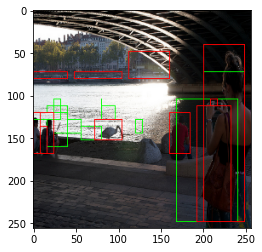

In [108]:
n=10

_, img, _= coco_dataset_val.__getitem__(n)

img_np = img.permute(1,2,0).numpy()*255
pil_img = Image.fromarray(img_np.astype(np.uint8))
t_draw = ImageDraw.Draw(pil_img)

#t_draw.rectangle((args.bin_size*bin_box_x0, args.bin_size*bin_box_y0, args.bin_size*bin_box_x1, args.bin_size*bin_box_y1),
#                 outline=255)

pred = preds[n]
tgt = tgts[n]

print(pred)

for idx in range(len(pred[0]['boxes'])):
    print(pred[0]['boxes'], pred[0]['labels'])
    bin_box_x0 = pred[0]['boxes'][idx,0]
    bin_box_y0 = pred[0]['boxes'][idx,1]
    bin_box_x1 = pred[0]['boxes'][idx,2]
    bin_box_y1 = pred[0]['boxes'][idx,3]
    t_draw.rectangle((bin_box_x0, bin_box_y0, bin_box_x1, bin_box_y1),
                 outline=(0,255,0))
    
for idx in range(len(tgt[0]['boxes'])):
    print(tgt[0]['boxes'], tgt[0]['labels'])
    bin_box_x0 = tgt[0]['boxes'][idx,0]
    bin_box_y0 = tgt[0]['boxes'][idx,1]
    bin_box_x1 = tgt[0]['boxes'][idx,2]
    bin_box_y1 = tgt[0]['boxes'][idx,3]
    t_draw.rectangle((bin_box_x0, bin_box_y0, bin_box_x1, bin_box_y1),
                 outline=255)
    
plt.imshow(pil_img)